<html> <h1 style="font-style:bold; color:blue;"> Machine Learning in Finance </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-7 </h1> </html>

## LSTM (Long Short-Term Memory)

## GOLD-2022 dataset 
     
### Predictions of The Highest & Lowest prices DURING five(5) following minutes
- Early-Stopping
- Loss function: MSE

### length of analysed history (sliding window)- 50 minutes ago

#### dataset for training: 30.000 rows (minutes) ~ 1 month
#### train / test = 90 /10

___________________________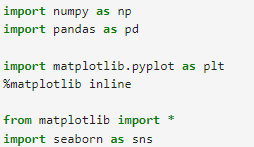

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import*
import seaborn as sns

_____________________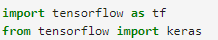

In [4]:
import tensorflow as tf
from tensorflow import keras

In [7]:
print(tf.__version__)

2.12.0


__________________

2.17.0


_____________________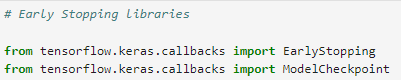

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

___________________

In [9]:
np.random.seed(19)

<html> <h2 style=" color:blue;"> Data </h2> </html>

In [10]:
# We use a slightly different normalisation principle for prices.
# We use the same principle as in the practical session in Week-6 for Volumes and Deltas.

# For normalisation, it is not necessary for the normalised columns' values to be in the range between [0,1].
# What is more important is that all the values ​​in these columns are approximately the same order of magnitude, 
# i.e. do not differ by hundreds or more times.

_____________________________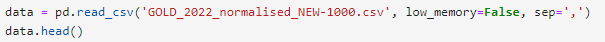

In [11]:
data = pd.read_csv('GOLD_2022_normalised_NEW-1000.csv', low_memory=False, sep=',')
data.head()

,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_day,New_week,Y_High_Bid,Y_Low_Ask
0,1.828604,1.829628,1.828544,1.829504,0.009718,1.829656,1.830936,1.829386,1.830196,0.009050,0.629054,0.000709,0.751830,0.691381,0.801417,0.836836,1,1,1.829628,1.829386
1,1.829504,1.830104,1.829398,1.830004,0.007151,1.829936,1.830676,1.829916,1.830632,0.009946,0.631369,0.002969,0.898229,0.865171,0.877922,0.851948,0,0,1.830104,1.829916
2,1.830098,1.830604,1.829998,1.830534,0.011126,1.830612,1.831226,1.830516,1.831146,0.016555,0.633130,0.005766,0.878867,0.853365,0.877922,0.855726,0,0,1.830604,1.830516
3,1.830534,1.830704,1.830504,1.830674,0.001991,1.831156,1.831306,1.831046,1.831046,0.006808,0.632720,0.005116,0.853365,0.858087,0.872255,0.912397,0,0,1.830704,1.831046
4,1.830674,1.830674,1.830448,1.830508,0.006660,1.831026,1.831181,1.830886,1.831086,0.010739,0.632227,0.004332,0.917119,0.880520,0.896812,0.863754,0,0,1.830674,1.830886


_____________________________

___________________________

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [12]:
# memory size reduction

columns_float =['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 
                'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask', 
                'Volume_Delta', 'Volume_Delta_abs', 
                'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
                'Y_High_Bid', 'Y_Low_Ask']

columns_integer =['New_day', 'New_week']



_____________________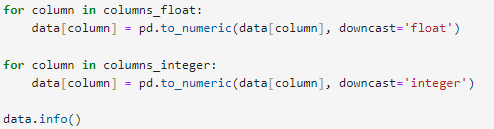

In [13]:
for c in columns_float:
    data[c] = pd.to_numeric(data[c], downcast='float')
for c in columns_integer:
    data[c] = pd.to_numeric(data[c], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354694 entries, 0 to 354693
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Open_Bid          354694 non-null  float32
 1   High_Bid          354694 non-null  float32
 2   Low_Bid           354694 non-null  float32
 3   Close_Bid         354694 non-null  float32
 4   Volume_Bid        354694 non-null  float32
 5   Open_Ask          354694 non-null  float32
 6   High_Ask          354694 non-null  float32
 7   Low_Ask           354694 non-null  float32
 8   Close_Ask         354694 non-null  float32
 9   Volume_Ask        354694 non-null  float32
 10  Volume_Delta      354694 non-null  float32
 11  Volume_Delta_abs  354694 non-null  float32
 12  Open_Delta        354694 non-null  float32
 13  High_Delta        354694 non-null  float32
 14  Low_Delta         354694 non-null  float32
 15  Close_Delta       354694 non-null  float32
 16  New_day           35

_____________________________

_____________________________

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

<Figure size 1200x500 with 0 Axes>

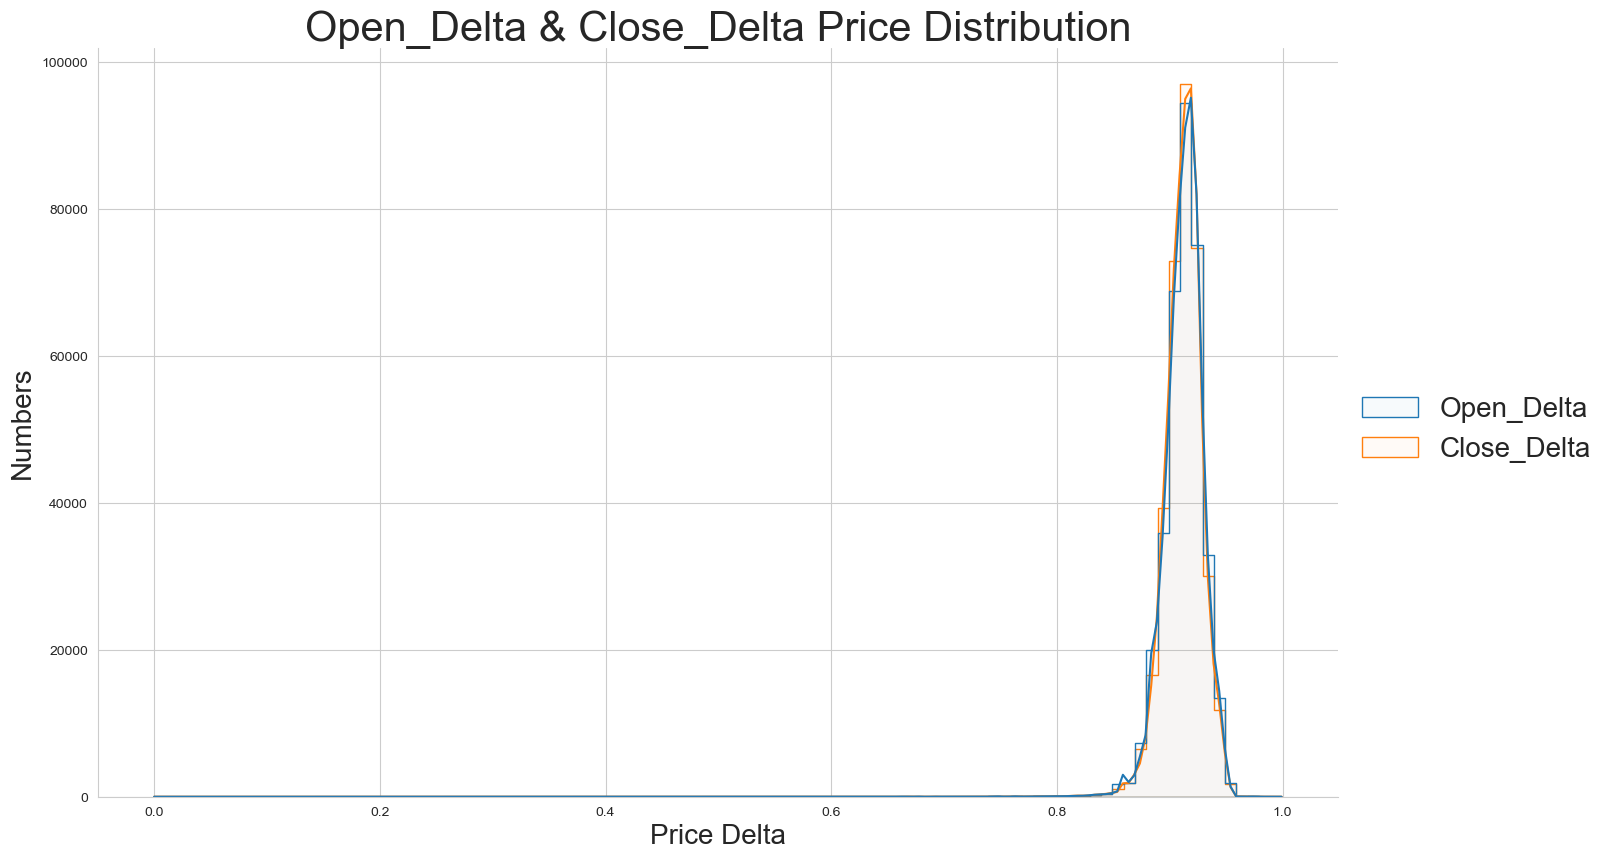

In [33]:
fig = plt.figure(figsize=(12, 5))
plt.rc('axes', titlesize= 30 ) 
sns.set_style('whitegrid')
sns.set_context(rc={'legend.fontsize': 20.0}) 

sns.displot( 
            data[['Open_Delta', 'Close_Delta']],
            height=8,
            aspect=1.7,
            kde=True,
            element="step",
            bins=100,
            alpha=0.03,          
                        
)

plt.title('Open_Delta & Close_Delta Price Distribution')
plt.xlabel('Price Delta', size= 20)
plt.ylabel('Numbers', size= 20)
plt.show();

<html> <h3 style="font-style:italic; color:blue;"> Date Transformation </h3> </html>

In [34]:
# We will predict the Highest and Lowest prices DURING the next 5 minutes. 

# To do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up, 
# and find max and min prices during these 5 minutes
# Then you need to delete the 5 last rows since there are no prices for the next 5 minutes. 
# Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 5 rows up.

_________________________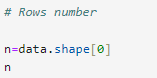

In [35]:
n= data.shape[0]
n

354694

_________________________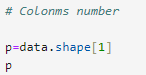

In [36]:
p=data.shape[1]
p

20

__________________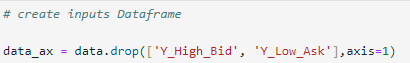

In [37]:
data_ax = data.drop(['Y_High_Bid', 'Y_Low_Ask'], axis=1)

________________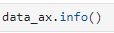

__________________________

__________________________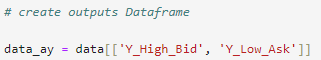

In [38]:
data_ay = data[['Y_High_Bid', 'Y_Low_Ask']]

________________

In [39]:
data_ay.head(4)

,Y_High_Bid,Y_Low_Ask
0,1.829628,1.829386
1,1.830104,1.829916
2,1.830604,1.830516
3,1.830704,1.831046


___________________

_________________________

______________________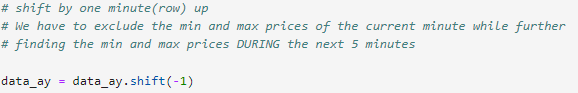

In [40]:
data_ay = data_ay.shift(-1)

____________________

In [41]:
data_ay.head(4)

,Y_High_Bid,Y_Low_Ask
0,1.830104,1.829916
1,1.830604,1.830516
2,1.830704,1.831046
3,1.830674,1.830886


____________________

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [42]:
# create new colomns: MIN_Lowest(Low_Ask) and MAX_Highest(High_Bid) prices of DURING NEXT 5 minutes

# Forward-looking window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)

data_ay['Y_High_Bid_5'] = data_ay['Y_High_Bid'].rolling(window=indexer).max()
data_ay['Y_Low_Ask_5']  = data_ay['Y_Low_Ask'].rolling(window=indexer).min()

___________________

_______________________

__________________________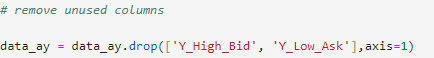

In [43]:
data_ay = data_ay.drop(['Y_High_Bid', 'Y_Low_Ask'], axis=1)

____________________

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

In [44]:
# delete the 5 last rows in data_ay (because we don't have answers for the last 5 minutes)

for i in range(5):
        data_ay.drop(data_ay.shape[0]-1, axis=0, inplace=True)


In [45]:
# delete the last 5 rows in data_ax (because we don't have answers for the last 5 minutes)

for i in range(5):
    data_ax.drop(data_ax.shape[0]-1, axis=0, inplace=True)

_______________________

____________________

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [46]:
# Create inputs Numpy

data_a = np.array(data_ax) 

with np.printoptions(precision=4):
    print("data_a:")
    print(data_a[:2,:])  
    print('\n')
    print(data_a[-2:,:]) 

print("numpy size: = ", data_a.shape)
print("type: ", data_a.dtype) 


data_a:
[[1.8286e+00 1.8296e+00 1.8285e+00 1.8295e+00 9.7176e-03 1.8297e+00
  1.8309e+00 1.8294e+00 1.8302e+00 9.0501e-03 6.2905e-01 7.0896e-04
  7.5183e-01 6.9138e-01 8.0142e-01 8.3684e-01 1.0000e+00 1.0000e+00]
 [1.8295e+00 1.8301e+00 1.8294e+00 1.8300e+00 7.1508e-03 1.8299e+00
  1.8307e+00 1.8299e+00 1.8306e+00 9.9463e-03 6.3137e-01 2.9690e-03
  8.9823e-01 8.6517e-01 8.7792e-01 8.5195e-01 0.0000e+00 0.0000e+00]]


[[1.8243e+00 1.8244e+00 1.8243e+00 1.8243e+00 2.5520e-03 1.8250e+00
  1.8251e+00 1.8249e+00 1.8250e+00 2.3750e-03 6.2938e-01 1.8801e-04
  8.5053e-01 8.5762e-01 8.7178e-01 8.5762e-01 0.0000e+00 0.0000e+00]
 [1.8244e+00 1.8245e+00 1.8243e+00 1.8243e+00 1.7923e-03 1.8250e+00
  1.8251e+00 1.8250e+00 1.8250e+00 1.3867e-03 6.2923e-01 4.3086e-04
  8.6470e-01 8.6470e-01 8.5762e-01 8.5762e-01 0.0000e+00 0.0000e+00]]
numpy size: =  (354689, 18)
type:  float32


In [47]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [48]:
# Create outputs Numpy

data_y = np.array(data_ay) 

print("data_a:")
print(data_y[:3,:])  
print('\n')
print(data_y[-3:,:]) 

print("numpy size: = ", data_y.shape)
print("type: ", data_y.dtype) 

data_a:
[[1.83070397 1.829916  ]
 [1.83070397 1.83004606]
 [1.83070397 1.82989597]]


[[1.82447803 1.82425201]
 [1.82447803 1.82385194]
 [1.82434797 1.82385194]]
numpy size: =  (354689, 2)
type:  float64


In [49]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

<html> <h3 style="font-style:italic; color:blue;"> Create the 3D inputs tensor, and 2D outputs matrix </h3> </html>

In [50]:
# We will analyse only part of the dataset since training the neural network with 
# an entire dataset would require massive computer power.

# n_small = 30,000 rows (minutes), which equals around 1 month.

# We need a three-dimensional data tensor: [(n_small-N ), N, 18] and
# two-dimensional array of answers [(n_small-N ), 2] with the High and Low prices DURING the next 5 minutes

# where N=50 is the number of minutes for analysis at each step; those are looking backwards 

# Therefore, we need:
# three-dimensional data tensor of sliced graphs [(n_small - N - 5), N, 18] and
# two-dimensional matrix of answers Y[(n_small - N - 5), 2] with the High and Low prices shifted sequentially to 5 rows up.

________________________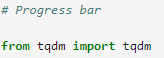

In [53]:
from tqdm import tqdm

___________________________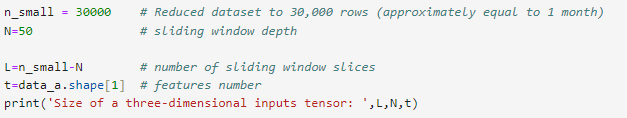

In [54]:
n_small = 30000
N=50
L=n_small-N
t=data_a.shape[1]
print('Size:', L,N,t)

Size: 29950 50 18


#### Now just press 'CTRL' and 'ENTER' keys on the next 3 cells.

In [55]:
# create imputs zeros 3D tensors with 'float32'

data_b = np.zeros( (L, N, t), dtype= 'float32' ) 

In [56]:
# create a two-dimensional zeros vector of answers - normalised the High_Bid and Low_Ask prices DURING next 5 minutes

Y = np.zeros((L, 2), dtype= 'float32') # We will predict two prices - normalised High_Bid and normalised Low_Ask

In [57]:
# fill the imputs 3D tansor (data_b) 
# and the array of answers Y 

#print('L = n - N = ', n-N, L)
print('L = n_small - N - 5 = ', n_small-N-5, L)
#for k in tqdm(range(L-1)):
for k in tqdm(range(L)):
    data_b[k, :, :] = data_a[k:k+N, :]   
                                          
    Y[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 5 minutes future price
    Y[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 5 minutes future price

print(k) # index value (for control)
    
print('data_b:', '\n', data_b)
print("Numpy size:        ", data_b.shape, '\n')

print( Y[:5,:])
print( Y[-10:,:])
print(      "Numpy size:         ", Y.shape)

L = n_small - N - 5 =  29945 29950


100%|█████████████████████████████████| 29950/29950 [00:00<00:00, 406543.18it/s]

29949
data_b: 
 [[[1.828604   1.829628   1.828544   ... 0.8368359  1.         1.        ]
  [1.829504   1.830104   1.829398   ... 0.851948   0.         0.        ]
  [1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  ...
  [1.828188   1.828198   1.828058   ... 0.9048406  0.         0.        ]
  [1.828178   1.828178   1.827978   ... 0.90247935 0.         0.        ]
  [1.827998   1.828058   1.827968   ... 0.90247935 0.         0.        ]]

 [[1.829504   1.830104   1.829398   ... 0.851948   0.         0.        ]
  [1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  [1.830534   1.830704   1.830504   ... 0.91239667 0.         0.        ]
  ...
  [1.828178   1.828178   1.827978   ... 0.90247935 0.         0.        ]
  [1.827998   1.828058   1.827968   ... 0.90247935 0.         0.        ]
  [1.828048   1.828158   1.827898   ... 0.89681226 0.         0.        ]]

 [[1.830098   1.830604   1.829998   ... 0.85572606 0.         0.        ]
  [1.8

In [58]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [59]:
# Control of the correctness of filling the array Y 
# (should show MAX of the normalised prices High_Bid and Low_Ask - during 5 next minutes(step) ahead)


import random

pp = random.randint(50, L) # (any number before 29950) - just to look at the middle of data_b
print('random int = ', pp)

print('data_b:', '\t\t','Y:')
print('Y_High_Bid ','\t\t','Y_High_Bid')

for i in range(15):
    print(data_b[pp+i,N-1,1], '\t\t', Y[pp+i,0])

random int =  23756
data_b: 		 Y:
Y_High_Bid  		 Y_High_Bid
1.844158 		 1.844638
1.844348 		 1.844638
1.844588 		 1.844638
1.844638 		 1.844408
1.844408 		 1.844368
1.843968 		 1.844588
1.844368 		 1.845108
1.844358 		 1.845278
1.844198 		 1.845478
1.844254 		 1.845478
1.844588 		 1.845478
1.845108 		 1.845478
1.845278 		 1.845478
1.845478 		 1.845398
1.845398 		 1.845128


In [60]:
# Chech the result:
# Your result from running the cell above must match the result in this cell.

In [61]:
# Each rows of Y above must have maximum of prices of 5 minute ahead

_________________________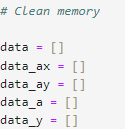

In [62]:
data =[]
ata_ax = []
data_ay =[]
data_a = []
data_y = []

<html> <h2 style="font-style:italic; olor:blue;"> Train Test Split </h2> </html>

- 90% for training and validation
- 10% for testing

_________________________

In [70]:
from sklearn.model_selection import train_test_split

<html> <h3 style="font-style:bold; color:red;"> !!! Use parameters: shuffle = False, stratify = None

Otherwise, the whole time series will be mixed up!
</h3> </html>

________________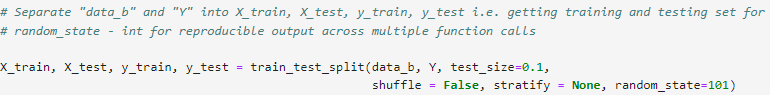

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data_b, Y, test_size=0.1,
                                                    shuffle = False, stratify = None, random_state=101)

_____________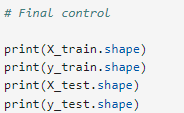

In [72]:
print(X_train.shape)
print(y_test.shape)

(26955, 50, 18)
(2995, 2)


<html> <h2 style="color:blue;"> Training </h2> </html>

<html> <h3 style="color:blue;"> LSTM </h3> </html>

___________________________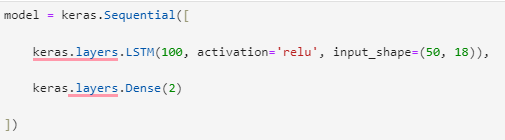

In [73]:
model = keras.Sequential([
    keras.layers.LSTM(100, activation='relu', input_shape=(50, 18)),
    keras.layers.Dense(2)
])

_________________________

In [74]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 47,802
Trainable params: 47,802
Non-trainable params: 0
_________________________________________________________________
None


<html> <h3 style="font-style:italic; color:blue;"> Callbacks </h3> </html>

__________________________

In [75]:
model.compile(optimizer = "adam", loss="mse", metrics=["mae"])

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

In [76]:
# Early Stopping parameters

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model_LSTM_GOLD.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

<html> <h4 style="font-style:bold; color:red;"> If you are using your own laptop without a GPU (Graphics processing unit), 

please change the following parameter in the next cell  </h4> </html>
<html> <h3 style="font-style:bold; color:blue;">
epochs=10
</h3> </html>


__________________________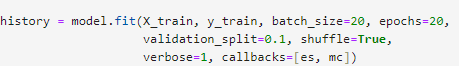

In [77]:
history= model.fit(X_train, y_train, batch_size=20, epochs=20, validation_split=0.1, shuffle=True, verbose=1, callbacks=[es, mc])

Epoch 1/20


2024-12-14 13:24:13.721019: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1212/1213 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0125
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 18s 14ms/step - loss: 0.0056 - mae: 0.0125 - val_loss: 1.6619e-05 - val_mae: 0.0031
Epoch 2/20
1212/1213 [============================>.] - ETA: 0s - loss: 1.3308e-05 - mae: 0.0028
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 17s 14ms/step - loss: 1.3309e-05 - mae: 0.0028 - val_loss: 1.6104e-05 - val_mae: 0.0034
Epoch 3/20
1213/1213 [==============================] - ETA: 0s - loss: 8.4676e-06 - mae: 0.0023
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 17s 14ms/step - loss: 8.4676e-06 - mae: 0.0023 - val_loss: 1.5160e-05 - val_mae: 0.0033
Epoch 4/20
1210/1213 [==========================

_______________________________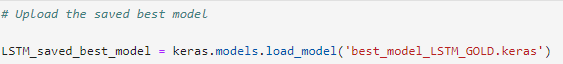

In [92]:
print(tf.__version__)

2.12.0


In [80]:

LSTM_saved_best_model = keras.models.load_model('best_model_LSTM_GOLD.keras')


<html> <h3 style="font-style:italic; color:blue;"> Test </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next 4 cells.

In [81]:
# Evaluate the quality of network training on test data, which the network has NOT seen.

scores = LSTM_saved_best_model.evaluate(X_test, y_test, verbose=1)

94/94 [==============================] - 1s 5ms/step - loss: 1.1810e-06 - mae: 6.4431e-04


In [82]:
scores

[1.1809586339950329e-06, 0.0006443095626309514]

In [83]:
print("Mean squared error (mse): %.9f " % (scores[0]))

Mean squared error (mse): 0.000001181 


In [84]:
print("Mean absolute error (mae): %.9f " % (scores[1]))

Mean absolute error (mae): 0.000644310 


<html> <h2 style="font-style:italic; color:blue;"> Visualisation </h2> </html>

<html> <h3 style="font-style:italic; color:blue;"> MSE training graphs </h3> </html>

___________________________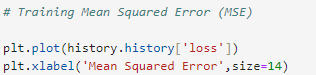

#### Now just press 'CTRL' and 'ENTER' keys on the next 2 cells.

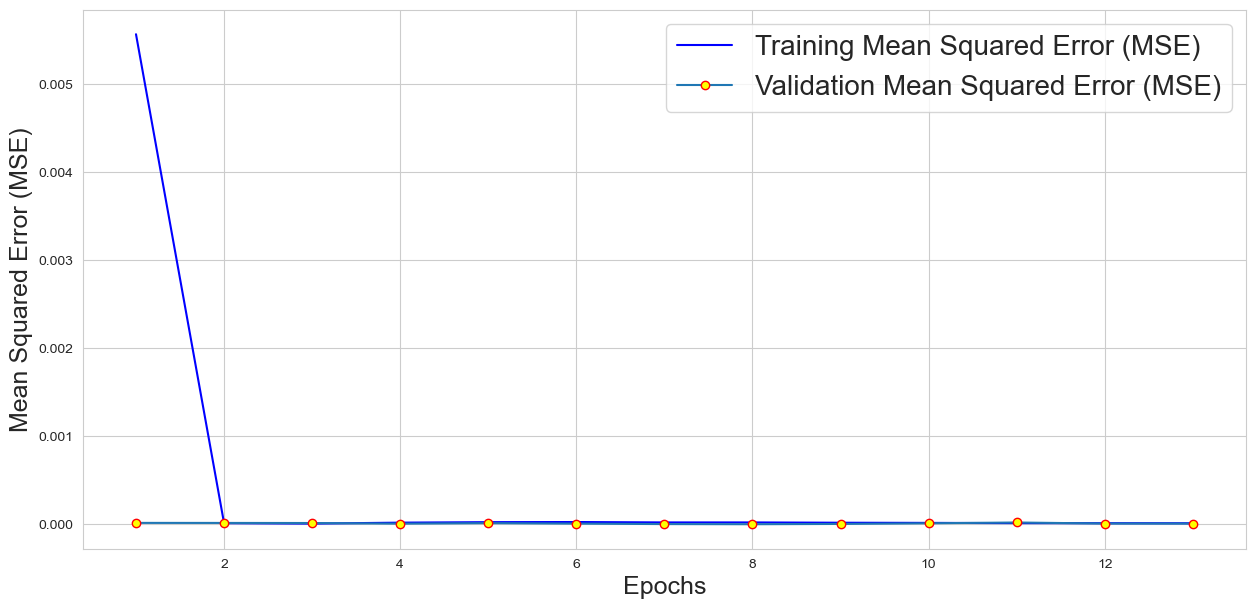

In [85]:
# More detailed MSE graph

history_dict = history.history

mse_values = history_dict['loss']
val_mse_values = history_dict['val_loss']

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

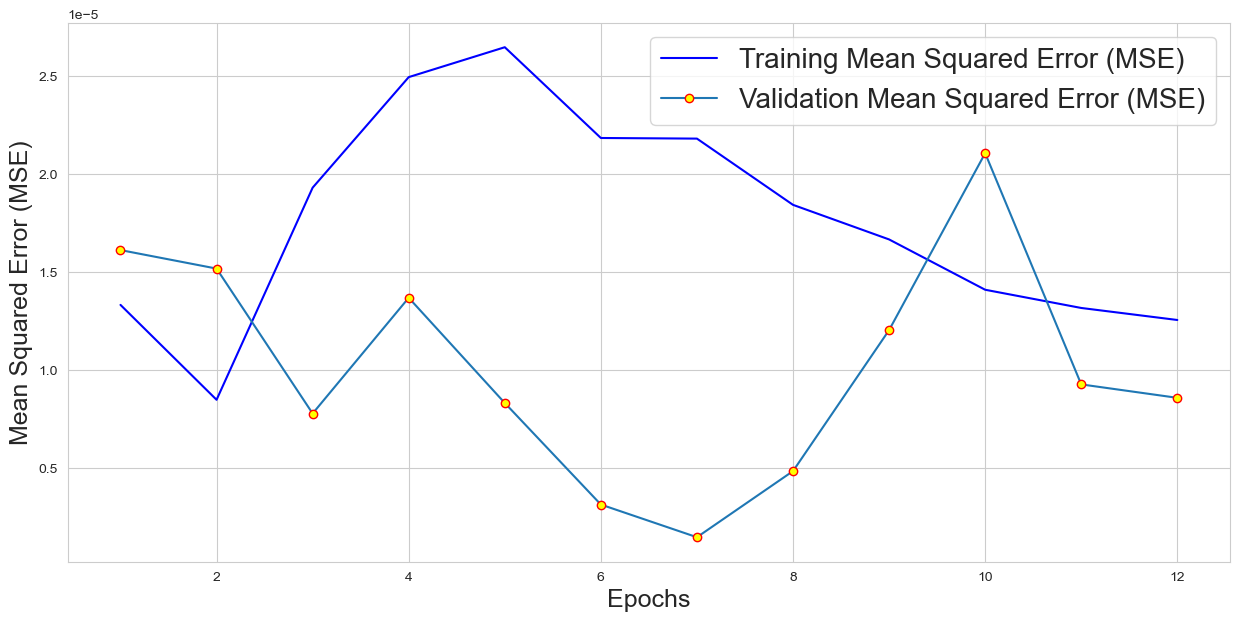

In [86]:
# deleted the 1st epoch
# to examine in detail the results of the remaining epochs

history_dict = history.history

mse_values = history_dict['loss'][1:]
val_mse_values = history_dict['val_loss'][1:]

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

<html> <h3 style="font-style:italic; color:blue;"> MAE training graphs </h3> </html>

__________________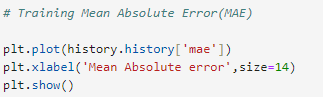

____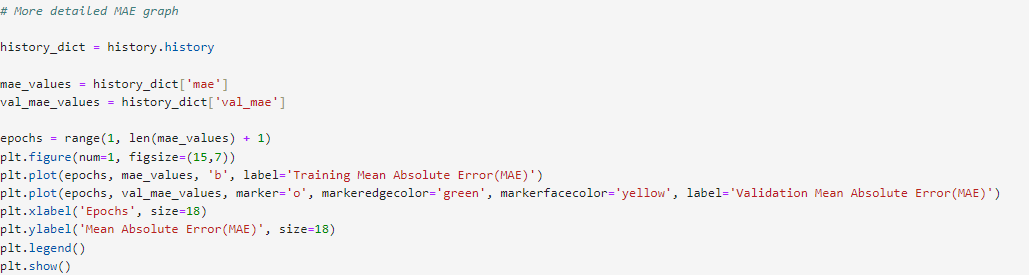

<html> <h3 style="font-style:italic; color:blue;"> Prediction 5 minute ahead </h3> </html>

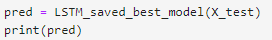

In [87]:
pred = LSTM_saved_best_model(X_test)
print(pred)

tf.Tensor(
[[1.7843882 1.7832916]
 [1.7844878 1.7833084]
 [1.7841672 1.78284  ]
 ...
 [1.8002114 1.8003858]
 [1.7997261 1.8001277]
 [1.8004507 1.799921 ]], shape=(2995, 2), dtype=float32)


<html> <h3 style="font-style:italic; color:blue;"> Price chart </h3> </html>

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

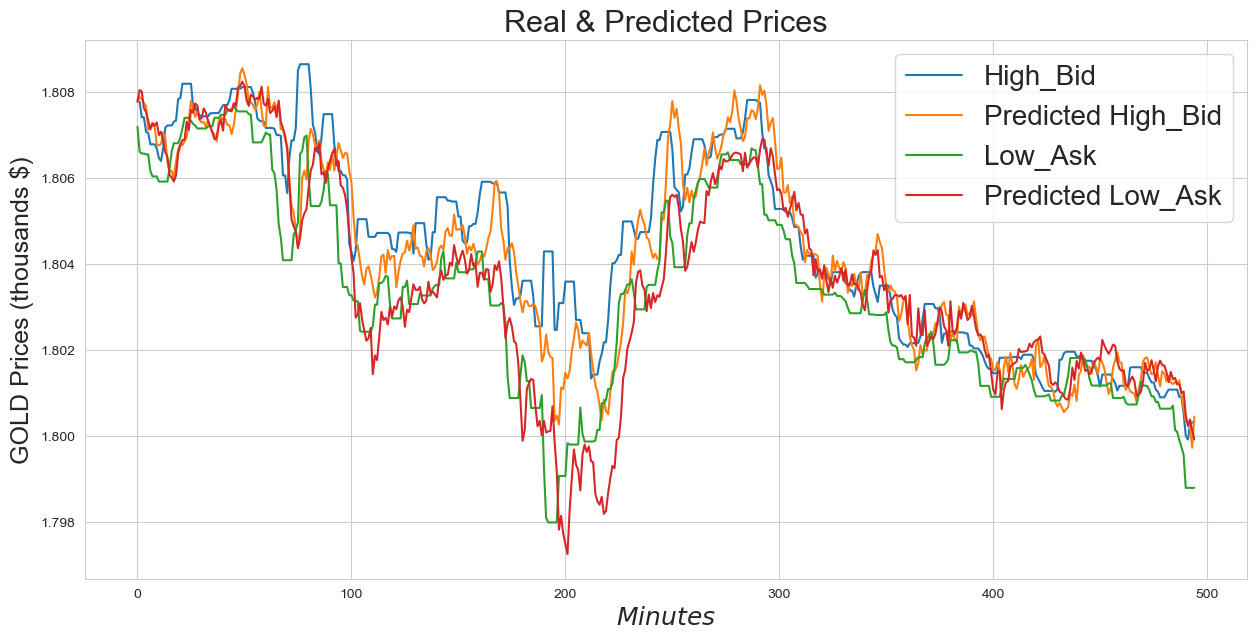

In [88]:
N1=2500  # The first minute for the chart  
LL = 500  # Duration (in minutes) for the chart
N2=N1+LL  # the last minute for the chart

plt.ion()
fig = plt.figure(figsize=(15,7))  

ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test[N1:N2,0], label='High_Bid')
line2, = ax1.plot(pred[N1:N2,0], label='Predicted High_Bid')
line3, = ax1.plot(y_test[N1:N2,1], label='Low_Ask')
line4, = ax1.plot(pred[N1:N2,1], label='Predicted Low_Ask')

plt.title('Real & Predicted Prices', size=22)
plt.ylabel('GOLD Prices (thousands $)', size=18)
plt.xlabel('$Minutes$', size=18)
plt.legend(loc='upper right') 

plt.show()


<html> <h3 style="font-style:italic; color:blue;"> Error Chart </h3> </html>

__________________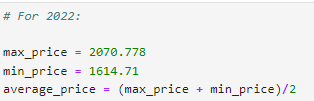

In [89]:
max_price = 2070.778
min_price = 1614.71
average_price = (max_price + min_price)/2

#### Now just press 'CTRL' and 'ENTER' keys on the next cell.

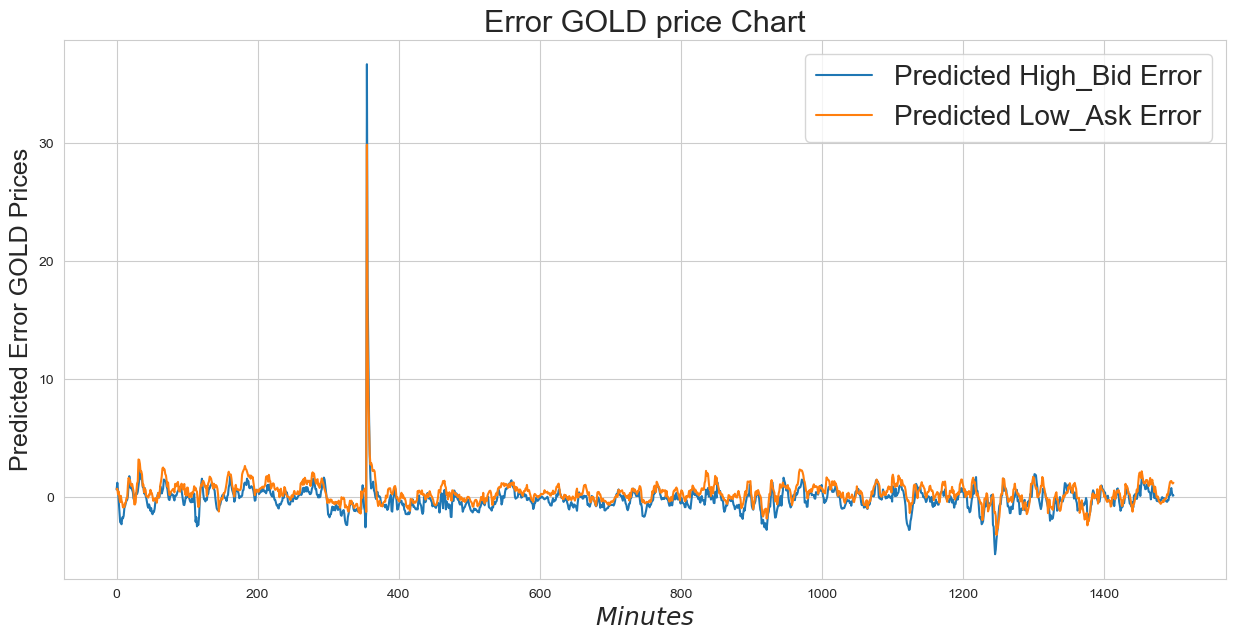

In [90]:
N1=0  # The first minute for the chart  
LL = 1500  # leigt (in minutes) for the chart
N2=N1+LL  # the last minute for the chart
# N2 should be < len(pred)

plt.ion()
fig = plt.figure(figsize=(15,7))  

ax1 = fig.add_subplot(111)

# in $ (absolute price)
a = (pred[N1:N2,0] - y_test[N1:N2,0]) *1000
b = (pred[N1:N2,1] - y_test[N1:N2,1]) *1000

# in %
#a = (pred[N1:N2,0] - y_test[N1:N2,0]) *1000/ average_price *100
#b = (pred[N1:N2,1] - y_test[N1:N2,1]) *1000/ average_price *100


line1, = ax1.plot(a, label='Predicted High_Bid Error')
line2, = ax1.plot(b, label='Predicted Low_Ask Error')

plt.title('Error GOLD price Chart', size=22)
plt.ylabel('Predicted Error GOLD Prices', size=18)
plt.xlabel('$Minutes$', size=18)
plt.legend(loc='upper right') 

plt.show()

# Lab Logbook Requirement:

<html> <h3 style="font-style:italic; color:blue;">
   
1) Modify the practical session LSTM model parameter from 100 to be calculated using the formula: 

   ZY + 10
   , where your SID is: XXXXXZY
   
3) Change the epochs to 10.
4) Change the patience to 3
5) Leave other parameters the same as in the practical session.
6) Compile the model.
6) Train your LSTM with the same datasets and demonstrate the received test MSE & MAE.
Compare your test MSE & MAE with the MSE & MAE of the LSTM in the practical session.
7) Please only add to your Lab Logbook print-screens of:
- your LSTM architecture using model.summary(),
- the resulting test MSE & MAE and
- MAE detailed graph


    
</h3> </html>

<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [103]:
SID = 2369402
Z = int(str(SID)[-2])  # Second last digit of SID
Y = int(str(SID)[-1])  # Last digit of SID
lstm_units = Z * Y + 10  # LSTM units formula

In [104]:
epochs = 10
patience = 3

# Model architecture
model = keras.Sequential([
    keras.layers.LSTM(lstm_units, activation='relu', input_shape=(50, 18)),
    keras.layers.Dense(2)
])

In [105]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1)
mc = ModelCheckpoint('best_model_LSTM_GOLD.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [106]:
history = model.fit(
    X_train, y_train,
    batch_size=20,
    epochs=epochs,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc]
)

Epoch 1/10
1203/1213 [============================>.] - ETA: 0s - loss: 0.1659 - mae: 0.1079
Epoch 1: val_loss improved from inf to 0.00053, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 6s 5ms/step - loss: 0.1645 - mae: 0.1071 - val_loss: 5.2982e-04 - val_mae: 0.0170
Epoch 2/10
1209/1213 [============================>.] - ETA: 0s - loss: 1.5853e-04 - mae: 0.0096
Epoch 2: val_loss improved from 0.00053 to 0.00011, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 6s 5ms/step - loss: 1.5827e-04 - mae: 0.0096 - val_loss: 1.0827e-04 - val_mae: 0.0084
Epoch 3/10
1210/1213 [============================>.] - ETA: 0s - loss: 7.5932e-05 - mae: 0.0069
Epoch 3: val_loss improved from 0.00011 to 0.00008, saving model to best_model_LSTM_GOLD.keras
1213/1213 [==============================] - 6s 5ms/step - loss: 7.5903e-05 - mae: 0.0069 - val_loss: 8.4986e-05 - val_mae: 0.0075
Epoch 4/10
1204/1213 [=====================

In [107]:
print("Model Summary:")
model.summary()

Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                1160      
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1,182
Trainable params: 1,182
Non-trainable params: 0
_________________________________________________________________


In [108]:
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("\nTest Results:")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x31ea1fe20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x31ea1fe20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: co

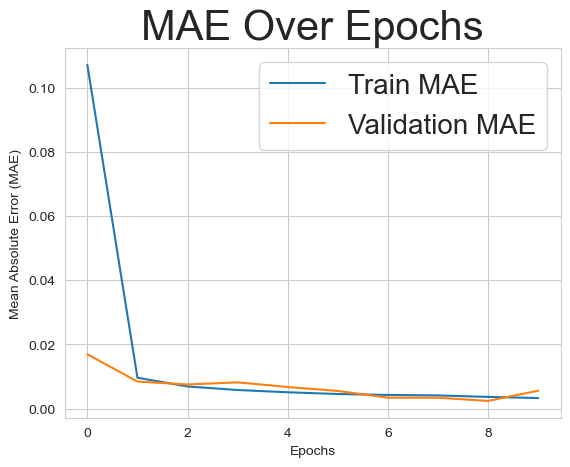

In [109]:
# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()